In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA


In [2]:
# Reading in data for station
df = pd.read_csv('../data/df_cleaned_year.csv')
df.head()

,datetime,c/a,unit,scp,station,linename,entries_abs,exits_abs,weekday
0,2022-04-16 04:00:00,H007,R248,00-00-00,1 AV,L,18,192,Saturday
1,2022-04-16 08:00:00,H007,R248,00-00-00,1 AV,L,8,101,Saturday
2,2022-04-16 12:00:00,H007,R248,00-00-00,1 AV,L,62,273,Saturday
3,2022-04-16 16:00:00,H007,R248,00-00-00,1 AV,L,91,473,Saturday
4,2022-04-16 20:00:00,H007,R248,00-00-00,1 AV,L,115,484,Saturday


In [3]:
# Selecting Penn Station
df = df[df['station'] == '34 ST-PENN STA']
df

,datetime,c/a,unit,scp,station,linename,entries_abs,exits_abs,weekday
962725,2022-04-16 04:00:00,N067,R012,00-00-00,34 ST-PENN STA,ACE,8,21,Saturday
962726,2022-04-16 08:00:00,N067,R012,00-00-00,34 ST-PENN STA,ACE,23,97,Saturday
962727,2022-04-16 12:00:00,N067,R012,00-00-00,34 ST-PENN STA,ACE,62,317,Saturday
962728,2022-04-16 16:00:00,N067,R012,00-00-00,34 ST-PENN STA,ACE,113,343,Saturday
962729,2022-04-16 20:00:00,N067,R012,00-00-00,34 ST-PENN STA,ACE,96,280,Saturday
...,...,...,...,...,...,...,...,...,...
1073409,2022-10-14 04:00:00,N072,R012,05-03-06,34 ST-PENN STA,ACE,10,25,Friday
1073410,2022-10-14 08:00:00,N072,R012,05-03-06,34 ST-PENN STA,ACE,85,64,Friday
1073411,2022-10-14 12:00:00,N072,R012,05-03-06,34 ST-PENN STA,ACE,104,89,Friday
1073412,2022-10-14 16:00:00,N072,R012,05-03-06,34 ST-PENN STA,ACE,58,259,Friday


In [4]:
# Looking at the columns and types 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110689 entries, 962725 to 1073413
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   datetime     110689 non-null  object
 1   c/a          110689 non-null  object
 2   unit         110689 non-null  object
 3   scp          110689 non-null  object
 4   station      110689 non-null  object
 5   linename     110689 non-null  object
 6   entries_abs  110689 non-null  int64 
 7   exits_abs    110689 non-null  int64 
 8   weekday      110689 non-null  object
dtypes: int64(2), object(7)
memory usage: 8.4+ MB


In [5]:
# Setting the datetime to a datetime object and setting as index
df['datetime'] = pd.to_datetime(df['datetime'])

#Using the groupby to add up the entries and exits for each time
df = df.groupby('datetime').sum()
df.head()

#Renaming the columns and sorting the index
df.rename(columns = {'entries_abs':'entries', 'exits_abs':'exits'}, inplace = True)
df.sort_index(inplace = True)
df.index.freq = '4H'

#Adding column for entries + exits called traffic
df['traffic'] = df['entries'] + df['exits']
df.head()

,entries,exits,traffic
datetime,,,
2022-04-16 04:00:00,646,1256,1902
2022-04-16 08:00:00,2533,5232,7765
2022-04-16 12:00:00,4308,9402,13710
2022-04-16 16:00:00,12280,23098,35378
2022-04-16 20:00:00,9069,15374,24443


In [6]:
def plot_series(df, cols, title='Title', xlab=None, ylab=None):
    """Function to plot columns for a time period"""
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    
    # Iterate through each column name.
    for col in cols:
        
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col], label = col)
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    
    plt.legend();

# Plots of the data

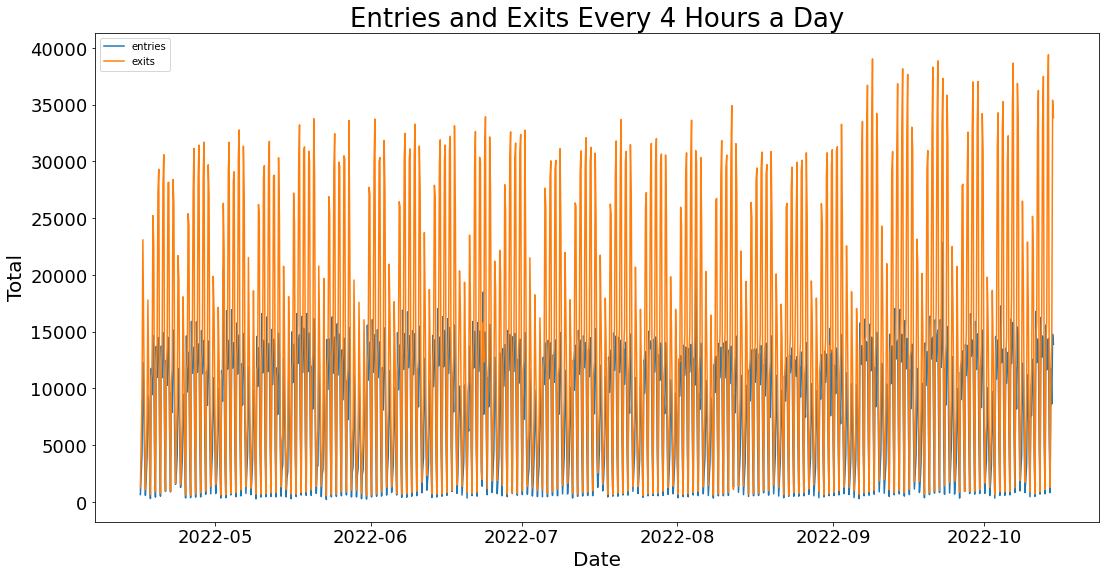

In [7]:
plot_series(df, cols = ['entries', 'exits'], title = 'Entries and Exits Every 4 Hours a Day', xlab = 'Date', ylab = 'Total')

- There appear to be far more exits than entries when we graph the data. We can see little a general pattern in the data as it spikes with times in the day.

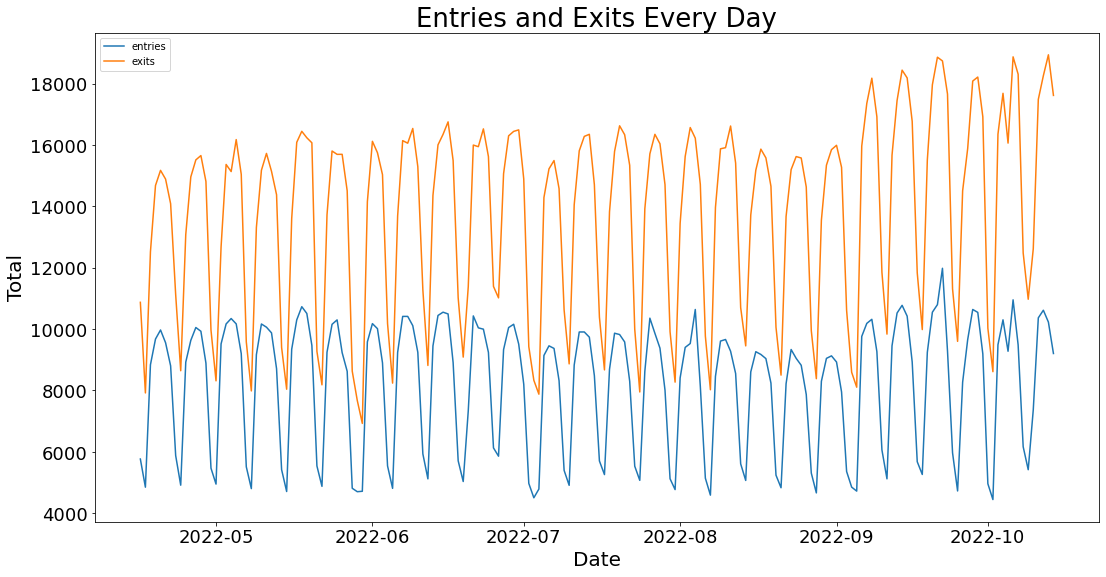

In [9]:
df_daily = df.resample('D').mean()
plot_series(df_daily, cols = ['entries', 'exits'], title = 'Entries and Exits Every Day', xlab = 'Date', ylab = 'Total')

- After resampling the data to be the average we can see the general patterns. They seem to go through weekly cycles where it will dip on the weekends in ridership and peak in the middle of the week.

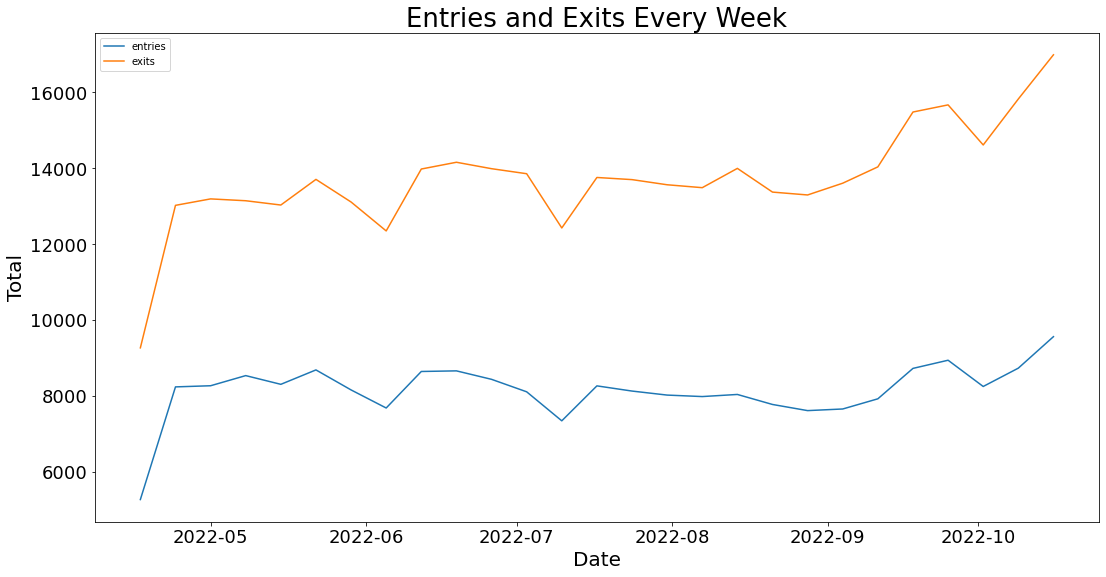

In [10]:
df_weekly = df.resample('W').mean()
plot_series(df_weekly, cols = ['entries', 'exits'], title = 'Entries and Exits Every Week', xlab = 'Date', ylab = 'Total')

- After taking the average of a week however the cycles are gone and we can see a slightly higher trend as the months progress towards winter

# Evaluating For Stationarity

In [11]:
# Use the augmented dickey-fuller test to test if our data is stationary
# Code from lesson on Arima Models to extract needed values 
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [12]:
interpret_dftest(adfuller(df['entries']))

Test Statistic   -1.144211e+01
p-value           6.142676e-21
dtype: float64

In [13]:
interpret_dftest(adfuller(df['exits']))

Test Statistic   -1.035992e+01
p-value           2.411413e-18
dtype: float64

- Since we have p values of less than 0.05 we can confidently say our data is stationary. This means we won't have to difference our data for our AR model

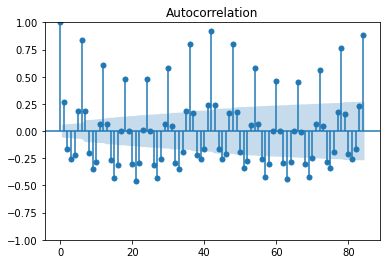

In [14]:
plot_acf(df['entries'], lags = 84);

- We can see that we have high correlation in every lag of 6. This is because for each lag of 6 an entire day passes. It also gets extremely high once it reaches 42 because thats after an entire week passes.

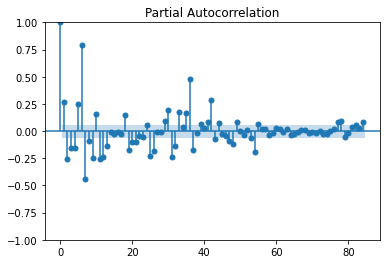

In [15]:
plot_pacf(df['entries'], lags = 84, method = 'ywm');

 - Using the pacf we can see that some of the correlation the acf was showing us was due to lags having a correlation to the lags in between the first lag. The majority of the lags of multiples of 6 are still standing out, but some of the negative lags in between for the autocorrelation below the significance threshold now. 

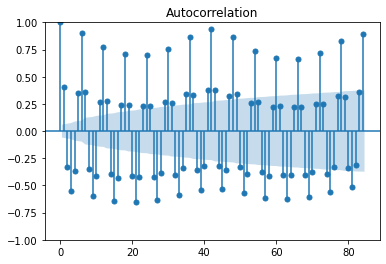

In [16]:
plot_acf(df['exits'], lags = 84);

- Opposed to the entries acf we have more negatively correlated lags and their significance is almost just as high as the positive lags' correlation.

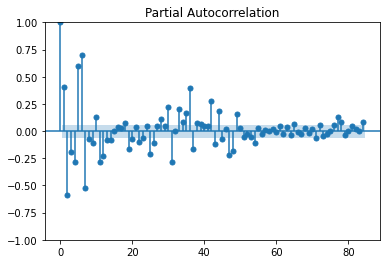

In [17]:
plot_pacf(df['exits'], lags = 84, method = 'ywm');

- We get the same drop off again however and see that most of the lags are the middle aren't as significant as they were in comparison to the acf.

# Evaluating AR Models For Entries

In [18]:
def AR_model_gridsearch(df, p_values, d_values, q_values):
    '''Grid search on ARIMA model, optimizing for AIC'''
    #Creating train test split for data
    y_train, y_test = train_test_split(df, test_size = 0.15, shuffle = False)
    
    best_aic = 999999
    best_order  = (0, 0, 0)
    for p in p_values: 
        for d in d_values:
            for q in q_values:
                try: 
                    
                    print(f'ARIMA:({p},{d},{q})')
                    
                    arima = ARIMA(endog = y_train, order = (p, d, q), freq = '4H')
                    
                    model = arima.fit()
                    
                    print(f'The AIC for ARIMA({p}, 0, {q}) is : {model.aic}')
                    
                    if model.aic < best_aic:
                        best_aic = model.aic
                        best_order = (p, d, q)
                        
                except:
                    print('failed')
                    pass
                
    print()
    print()
    print(f'Our model that minimizes AIC on the training data is the ARIMA{best_order}.')
    print(f'This model has an AIC of {best_aic}.')
    return best_order

In [35]:
def evaluate_model(df, p_value, d_value, q_value):
    '''Evaluating model on MAE, MAPE and RMSE'''
    y_train, y_test = train_test_split(df, test_size = 0.15, shuffle = False)

    arima = ARIMA(endog = y_train, order = (p_value, d_value, q_value), freq = '4H')
    
    model = arima.fit()

    preds = model.predict(start = y_test.index[0], end = y_test.index[-1])
    print(model.summary())

    print(f'MAE: {mean_absolute_error(y_test, preds)}')
    print(f'MAPE: {mean_absolute_percentage_error(y_test, preds)}')

    print(f'RMSE: {mean_squared_error(y_test, preds, squared = False)}')
    
    plt.figure(figsize = (10, 6))
    plt.plot(y_test, label = 'y_test')
    plt.plot(y_test.index, preds, label = 'test_pred')
    plt.title("Predictions vs Actual")
    plt.xlabel("Date")
    plt.ylabel(f'Total {df.name}')
    plt.legend();

In [20]:
# Checking lags 0,19
p_values = range(0,20)
d_values = [0] #Since the data is already stationary
q_values = [0] # To check the MA of 1 lag

p, d, q = AR_model_gridsearch(df['entries'], p_values, d_values, q_values)

ARIMA:(0,0,0)
The AIC for ARIMA(0, 0, 0) is : 23920.11617708649
ARIMA:(1,0,0)
The AIC for ARIMA(1, 0, 0) is : 18446.4675278353
ARIMA:(2,0,0)
The AIC for ARIMA(2, 0, 0) is : 18386.221942974516
ARIMA:(3,0,0)
The AIC for ARIMA(3, 0, 0) is : 18360.473279458314
ARIMA:(4,0,0)
The AIC for ARIMA(4, 0, 0) is : 18340.055358803733
ARIMA:(5,0,0)
The AIC for ARIMA(5, 0, 0) is : 18287.92730529289
ARIMA:(6,0,0)
The AIC for ARIMA(6, 0, 0) is : 17337.66756572608
ARIMA:(7,0,0)
The AIC for ARIMA(7, 0, 0) is : 17126.797304975848
ARIMA:(8,0,0)
The AIC for ARIMA(8, 0, 0) is : 17120.957128704016
ARIMA:(9,0,0)
The AIC for ARIMA(9, 0, 0) is : 17062.761201783942
ARIMA:(10,0,0)
The AIC for ARIMA(10, 0, 0) is : 17042.322652417373
ARIMA:(11,0,0)
The AIC for ARIMA(11, 0, 0) is : 16981.46462153027
ARIMA:(12,0,0)
The AIC for ARIMA(12, 0, 0) is : 16923.454960083604
ARIMA:(13,0,0)
The AIC for ARIMA(13, 0, 0) is : 16909.888521921785
ARIMA:(14,0,0)
The AIC for ARIMA(14, 0, 0) is : 16911.635323382987
ARIMA:(15,0,0)
The AI

                               SARIMAX Results                                
Dep. Variable:                entries   No. Observations:                  927
Model:                ARIMA(19, 0, 0)   Log Likelihood               -8409.796
Date:                Sun, 23 Oct 2022   AIC                          16861.591
Time:                        21:19:23   BIC                          16963.062
Sample:                    04-16-2022   HQIC                         16900.299
                         - 09-17-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8121.2536    172.433     47.098      0.000    7783.292    8459.216
ar.L1          0.4223      0.050      8.395      0.000       0.324       0.521
ar.L2         -0.1140      0.044     -2.619      0.0

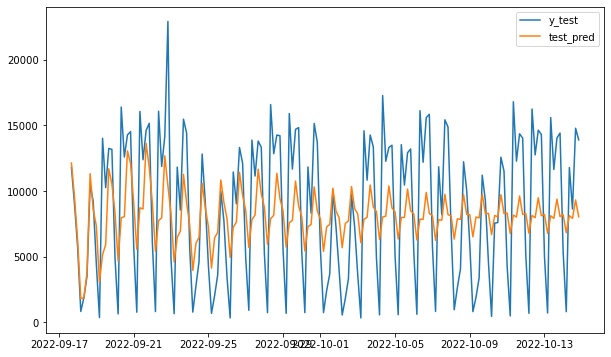

In [21]:
evaluate_model(df['entries'], p, d, q)

- As with the trend for autoregressive models as you try and forecast farther into the future the predictions start to just become the average since they can't add new data to pick up the trends. This model has a mean absolute percentage error of 169% which is quite high. The RMSE is 4507, which is quite high seeing the numbers we're dealing with.

# Evaluating Models for Exits

In [22]:
p_values = range(0,20)
d_values = [0] #Since the data is already stationary
q_values = [0] # To check the MA of 1 lag

p, d, q = AR_model_gridsearch(df['exits'], p_values, d_values, q_values)

ARIMA:(0,0,0)
The AIC for ARIMA(0, 0, 0) is : 25139.667892265064
ARIMA:(1,0,0)
The AIC for ARIMA(1, 0, 0) is : 19571.597336876075
ARIMA:(2,0,0)
The AIC for ARIMA(2, 0, 0) is : 19183.811219924108
ARIMA:(3,0,0)
The AIC for ARIMA(3, 0, 0) is : 19143.24913597369
ARIMA:(4,0,0)
The AIC for ARIMA(4, 0, 0) is : 19065.386804877493
ARIMA:(5,0,0)
The AIC for ARIMA(5, 0, 0) is : 18687.107728294784
ARIMA:(6,0,0)
The AIC for ARIMA(6, 0, 0) is : 17989.219804673434
ARIMA:(7,0,0)
The AIC for ARIMA(7, 0, 0) is : 17681.126927421003
ARIMA:(8,0,0)
The AIC for ARIMA(8, 0, 0) is : 17673.190029266225
ARIMA:(9,0,0)
The AIC for ARIMA(9, 0, 0) is : 17660.376258392527
ARIMA:(10,0,0)
The AIC for ARIMA(10, 0, 0) is : 17640.177217953136
ARIMA:(11,0,0)
The AIC for ARIMA(11, 0, 0) is : 17564.664436802803
ARIMA:(12,0,0)
The AIC for ARIMA(12, 0, 0) is : 17493.234932216496
ARIMA:(13,0,0)
The AIC for ARIMA(13, 0, 0) is : 17486.64431376764
ARIMA:(14,0,0)
The AIC for ARIMA(14, 0, 0) is : 17483.699621537933
ARIMA:(15,0,0)


C:\Users\injun\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(15, 0, 0) is : 17485.688426239118
ARIMA:(16,0,0)


C:\Users\injun\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(16, 0, 0) is : 17486.665422446695
ARIMA:(17,0,0)
The AIC for ARIMA(17, 0, 0) is : 17488.60625191997
ARIMA:(18,0,0)


C:\Users\injun\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(18, 0, 0) is : 17485.14430222001
ARIMA:(19,0,0)


C:\Users\injun\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(19, 0, 0) is : 17449.595385104694


Our model that minimizes AIC on the training data is the ARIMA(19, 0, 0).
This model has an AIC of 17449.595385104694.


C:\Users\injun\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                  exits   No. Observations:                  927
Model:                ARIMA(19, 0, 0)   Log Likelihood               -8703.798
Date:                Sun, 23 Oct 2022   AIC                          17449.595
Time:                        21:20:43   BIC                          17551.066
Sample:                    04-16-2022   HQIC                         17488.303
                         - 09-17-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.35e+04    235.018     57.459      0.000     1.3e+04     1.4e+04
ar.L1          0.4819      0.034     14.164      0.000       0.415       0.549
ar.L2         -0.0519      0.041     -1.255      0.2

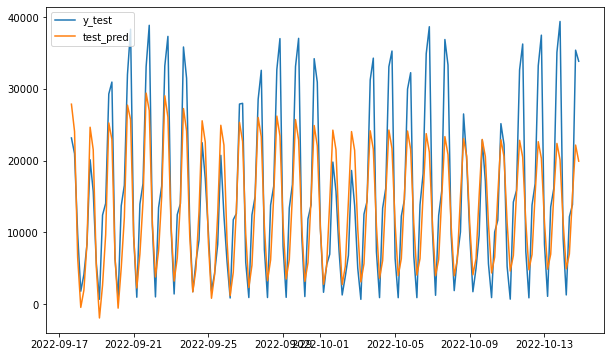

In [23]:
evaluate_model(df['exits'], p, d, q)


- For the exits the metrics are much better. The amount of exits seems to be less volatile compared to the entries. Thus having a lower mean absolute percentage error. The RMSE is actually higher than the entries however since quantity of exits is overall higher than entries. 

# Evaluating Models for Traffic

In [24]:
p_values = range(0,20)
d_values = [0] #Since the data is already stationary
q_values = [0] # To check the MA of 1 lag

p, d, q = AR_model_gridsearch(df['traffic'], p_values, d_values, q_values)

ARIMA:(0,0,0)
The AIC for ARIMA(0, 0, 0) is : 25852.180270369787
ARIMA:(1,0,0)
The AIC for ARIMA(1, 0, 0) is : 20312.749428115272
ARIMA:(2,0,0)
The AIC for ARIMA(2, 0, 0) is : 20076.872854662346
ARIMA:(3,0,0)
The AIC for ARIMA(3, 0, 0) is : 20036.09640904553
ARIMA:(4,0,0)
The AIC for ARIMA(4, 0, 0) is : 19983.925270791566
ARIMA:(5,0,0)
The AIC for ARIMA(5, 0, 0) is : 19767.69005969714
ARIMA:(6,0,0)
The AIC for ARIMA(6, 0, 0) is : 18873.3517861853
ARIMA:(7,0,0)
The AIC for ARIMA(7, 0, 0) is : 18544.36719677293
ARIMA:(8,0,0)
The AIC for ARIMA(8, 0, 0) is : 18524.446361787464
ARIMA:(9,0,0)
The AIC for ARIMA(9, 0, 0) is : 18482.319322972235
ARIMA:(10,0,0)
The AIC for ARIMA(10, 0, 0) is : 18406.85124180647
ARIMA:(11,0,0)
The AIC for ARIMA(11, 0, 0) is : 18318.653909408546
ARIMA:(12,0,0)
The AIC for ARIMA(12, 0, 0) is : 18227.211090039586
ARIMA:(13,0,0)
The AIC for ARIMA(13, 0, 0) is : 18182.9421588626
ARIMA:(14,0,0)
The AIC for ARIMA(14, 0, 0) is : 18182.379087139347
ARIMA:(15,0,0)
The AIC 

                               SARIMAX Results                                
Dep. Variable:                traffic   No. Observations:                  927
Model:                ARIMA(19, 0, 0)   Log Likelihood               -9016.665
Date:                Sun, 23 Oct 2022   AIC                          18075.330
Time:                        21:21:55   BIC                          18176.801
Sample:                    04-16-2022   HQIC                         18114.038
                         - 09-17-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.163e+04    282.734     76.486      0.000    2.11e+04    2.22e+04
ar.L1          0.4660      0.040     11.552      0.000       0.387       0.545
ar.L2          0.0048      0.037      0.131      0.8

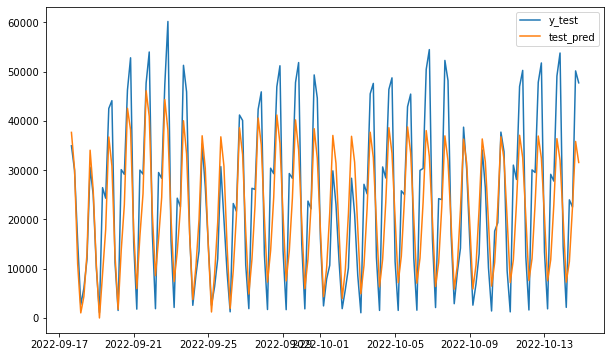

In [25]:
evaluate_model(df['traffic'], p, d, q)


- By adding up the entries and exits we can get an estimate for the traffic of a station at given time. The metrics for the MAPE are aroudn the same as the metrics for the number of exits. The RMSE is higher because it is the sum of the entries and exits, but it's similar MAPE shows it's classifying around the same error.

# Rolling Forecast Origin Model

In [39]:
def rolling_forecast(df, days, p, d ,q):
    '''Creates predictions by going back however many days and creating a model to predict 1 day ahead
       It will continue to predict until the last day
       Stores and returns the predictions of all these models'''
    rolling_preds = pd.Series()
    
    for i in range(days):
        train_test_separator = ((i - days) * 6)-1
        y_train = df[(i * 6):train_test_separator]
        y_test = df[train_test_separator:(train_test_separator+6)]

        arima = ARIMA(endog = y_train, order = (p, d, q), freq = '4H')

        model = arima.fit()

        preds = model.predict(start = y_test.index[0], end = y_test.index[-1])
        
        for index in y_test.index:
            rolling_preds.loc[index] = preds[index]

    return rolling_preds   

In [30]:
rolling_preds = rolling_forecast(df['entries'], 28, 19, d, q) 

C:\Users\injun\AppData\Local\Temp\ipykernel_3780\981836469.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  rolling_preds = pd.Series()


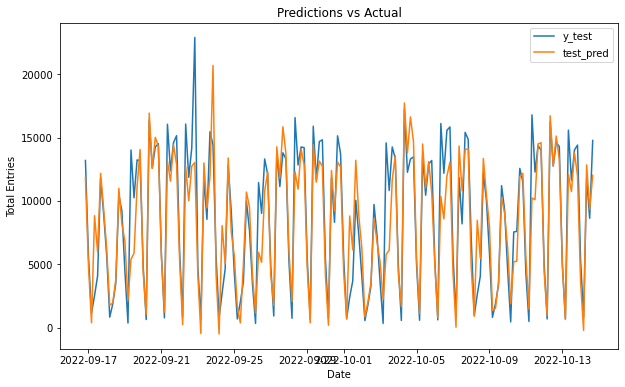

In [40]:
#Plotting predictions and actual values for the rolling forecast origin model
plt.figure(figsize = (10, 6))
plt.plot(df['entries'][-169:-1], label = 'y_test')
plt.plot(rolling_preds, label = 'test_pred')
plt.title("Predictions vs Actual")
plt.xlabel("Date")
plt.ylabel(f'Total Entries')
plt.legend();       

In [41]:
print(f"RMSE: {mean_squared_error(df['entries'][-169:-1], rolling_preds, squared = False)}")
print(f"MAPE: {mean_absolute_percentage_error(df['entries'][-169:-1], rolling_preds)}")

RMSE: 2356.265475069375
MAPE: 0.41903769557364356


- Looking at the graph we can see it matches much more closely to the actual predictions. Our RMSE is much lower than our first AR model being almost half. Our MAPE is nearly a quarter of the value at 42% versus the 169% seen in the original model. This is how a model should be implemented as it needs to continually bring in data to predict future dates. However how long we decided to predict into the future and how often we update our model would have to depend the resources we have for computing and the data we are allowed access to.